In [1]:
%matplotlib inline  
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random
import scipy.stats

import pickle as cPickle

import os
from scipy.io import loadmat

#Load the MNIST digit data
M = loadmat("mnist_all.mat")

#Display the 150-th "5" digit from the training set
#imshow(M["train5"][150].reshape((28,28)), cmap=cm.gray)
#show()


def softmax(y):
    '''Return the output of the softmax function for the matrix of output y. y
    is an NxM matrix where N is the number of outputs for a single case, and M
    is the number of cases'''
    return exp(y) / tile(sum(exp(y), 0), (len(y), 1))


def tanh_layer(y, W, b):
    '''Return the output of a tanh layer for the input matrix y. y
    is an NxM matrix where N is the number of inputs for a single case, and M
    is the number of cases'''
    return tanh(dot(W.T, y) + b)


def forward(x, W0, b0, W1, b1):
    L0 = tanh_layer(x, W0, b0)
    L1 = dot(W1.T, L0) + b1
    output = softmax(L1)
    return L0, L1, output

def deriv_multilayer(W0, b0, W1, b1, x, L0, L1, y, y_):
    dCdL1 = y - y_
    dCdW1 = dot(L0, dCdL1.T)
    dCdobydodh = dot(W1, dCdL1)
    one_minus_h_sq = 1 - L0**2

    dCdW0 = tile(dCdobydodh, 28 * 28).T * dot(x, (one_minus_h_sq.T))
    dCdb1 = dCdL1
    dCdb0 = dCdobydodh * one_minus_h_sq

    return dCdW1, dCdb1, dCdW0, dCdb0

In [2]:
def cross_entropy(y, y_):
    return -sum(y_ * log(y))

In [3]:
#Load sample weights for the multilayer neural network
def load_sample_weights():
    f = open("snapshot50.pkl", "rb")
    snapshot = cPickle.load(open("snapshot50.pkl", "rb"), encoding="latin1")
    W0 = snapshot["W0"]
    b0 = snapshot["b0"].reshape((300, 1))
    W1 = snapshot["W1"]
    b1 = snapshot["b1"].reshape((10, 1))
    return W0,b0,W1,b1

# L0, L1, output = forward(x, W0, b0, W1, b1)
# y = argmax(output)

# y_true = array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]).T
# print(deriv_multilayer(W0, b0, W1, b1,x, L0, L1, output, y_true))
################################################################################
# Code for displaying a feature from the weight matrix mW
# fig = figure(1)
# ax = fig.gca()
# heatmap = ax.imshow(W0[:, 50].reshape((28, 28)), cmap=cm.coolwarm)
# fig.colorbar(heatmap, shrink=0.5, aspect=5)
# show()
################################################################################

In [4]:
def get_batch(offset,example_per_class=5):
    # 5 examples per class
    classes_num = 10
    x_batch = np.zeros((example_per_class * classes_num, 28 * 28))
    y_batch = np.zeros((example_per_class * classes_num, classes_num))
    for i in range(classes_num):
        for j in range(example_per_class):
            x_batch[i * example_per_class + j] = M['train' + str(i)][j +
                                                                     offset]
            y_batch[i * example_per_class + j][i] = 1
    return x_batch, y_batch, example_per_class * classes_num

In [5]:
#Load one example from the training set, and run it through the
def test_image(x):
    _,_, output = forward(x, W0, b0, W1, b1)
    return argmax(output)

def test_performance_mult():
    hit = miss = 0
    for i in range(10):
        for image in M["test" + str(i)]:
            result = test_image(image.reshape(784,1))
            if result == i:
                hit+=1
            else:
                miss+=1
    return (float(hit)/float(hit + miss) * 100)

In [6]:
noise = scipy.stats.norm.rvs(scale=5,size=784*50*10)
noise = noise.reshape(500,784)
print(noise)

[[  7.26632851   3.49769574   8.13988462 ...,   2.84039219   9.96390563
    0.39279594]
 [ -6.89337682   2.19824206  -6.55675103 ...,   3.92334454   0.25187001
   -4.05619435]
 [ -1.84851291  -8.06161146   2.20786506 ...,  -6.32298993   0.18807834
   -0.75498748]
 ..., 
 [ -1.06677905   4.8458131  -11.01874563 ...,  -4.81548693   4.43243074
   -8.4372785 ]
 [ -3.68593627   4.14081154  -2.41968924 ...,   9.07896377  -1.62498993
    4.28396038]
 [  7.00829736  -8.38547935  -0.86335239 ...,  -2.08215517  -1.48149275
   -3.08939501]]


In [7]:
# Do gradient Descent
def train(plot=False):
    global W0, b0, W1, b1
    plot_iters = []
    plot_performance = []
    alpha = 1e-3
    X, Y, examples_n = get_batch(0,50)
    X += noise
    for i in range(30):
#         X, Y, examples_n = get_batch(i * 5,20)

        update = np.zeros(4)

        for j in range(examples_n):
            y = Y[j].reshape((10, 1))
            x = X[j].reshape((28 * 28, 1)) / 255.
            L0, L1, output = forward(x, W0, b0, W1, b1)
            gradients = deriv_multilayer(W0, b0, W1, b1, x, L0, L1, output, y)
            update = [update[k] + gradients[k] for k in range(len(gradients))]
            if (i * examples_n + j) % 500 == 0: 
                print("Iter %d" % (i * examples_n + j))
            
        # update the weights 
#         print("Updating over batch %s" % update)
        W1 -= alpha * update[0]
        b1 -= alpha * update[1]
        W0 -= alpha * update[2]
        b0 -= alpha * update[3]
        if plot:
            plot_iters.append(i * examples_n)
            plot_performance.append(test_perf())
    return plot_iters,plot_performance
W0,b0,W1,b1 = load_sample_weights()
train()

Iter 0
Iter 500
Iter 1000
Iter 1500
Iter 2000
Iter 2500
Iter 3000
Iter 3500
Iter 4000
Iter 4500
Iter 5000
Iter 5500
Iter 6000
Iter 6500
Iter 7000
Iter 7500
Iter 8000
Iter 8500
Iter 9000
Iter 9500
Iter 10000
Iter 10500
Iter 11000
Iter 11500
Iter 12000
Iter 12500
Iter 13000
Iter 13500
Iter 14000
Iter 14500


([], [])

In [8]:
def grad_descent(f, df, x, y, init_t, alpha):
    EPS = 1e-5
    prev_t = init_t-10*EPS
    t = init_t.copy()
    max_iter = 10000
    iter  = 0
    while iter < max_iter:
        prev_t = t.copy()
        t -= alpha*df(x, y, t)
        if iter % 500 == 0:
            print("Iter %d" % iter)
        iter += 1
    return t

def test_performance_linear(theta):
    hit = miss = 0
    for i in range(10):
        for image in M["test" + str(i)]:
            result = np.dot(np.append(ones(1),image/255.),theta.T)
            if result.argmax() == i:
                hit+=1
            else:
                miss+=1
    return (float(hit)/float(hit + miss)) * 100

In [9]:
def f(x, y, theta):
    x = hstack((ones((x.shape[0],1)), x))
    return sum(sum((y - dot(x,theta.T)) *7* 2))


def df(x, y, theta):
    x = hstack( (ones((x.shape[0],1)), x))
    return 2 * dot((dot(x,theta.T) - y).T,x)

X,Y,n = get_batch(0,50)
X = X/255. + noise 
theta0 = np.zeros(10 * 785)
theta0 = theta0.reshape(10,785)
theta = grad_descent(f, df, X, Y, theta0, 1e-7)
test_performance_linear(theta)

Iter 0
Iter 500
Iter 1000
Iter 1500
Iter 2000
Iter 2500
Iter 3000
Iter 3500
Iter 4000
Iter 4500
Iter 5000
Iter 5500
Iter 6000
Iter 6500
Iter 7000
Iter 7500
Iter 8000
Iter 8500
Iter 9000
Iter 9500


43.54

In [10]:
result_lin = test_performance_linear(theta)
result_mult = test_performance_mult()
print("Linear performance      | %.2f" % result_lin)
print("Multinomial performance | %.2f" % result_mult)

Linear performance      | 43.54
Multinomial performance | 82.92


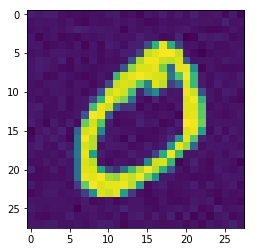

In [17]:
# visualize noisy image
X,Y,n = get_batch(0,50)
X += noise
noisy_image = X[0].reshape((28,28))
output = plt.imshow(noisy_image)
plt.savefig("images/noise_image.png")